In [4]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 31.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Assuming you have x as comments and y as features DataFrame
path_train='/content/drive/MyDrive/Toxicity Classification/dataset/train.csv'
df = pd.read_csv(path_train, encoding="utf-8")
# Preprocessing
# x = df['comment_text'].values  # Assuming 'comments' is the column name for comments
# y = df.iloc[:, 2:].values  # Assuming the 6 feature columns start from index 1



In [22]:
def clean(comment):
  import re
  comment=comment.lower()
  comment=re.sub(links,'',comment)
  comment=re.sub(ip_addr,'',comment)
  comment=re.sub(users,'',comment)
  comment=re.sub(newline,'',comment)
  return comment

In [24]:
links = '(http://.*?\s)|(http://.*)'
ip_addr = '\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}'
users = '\[\[User.*'
newline = '\\n'

df['comment_text'] = df['comment_text'].map(lambda i:clean(i))

# x = df['comment_text'].map(lambda i:clean(i)).values
print(df['comment_text'].str.contains(links).sum())
print(df['comment_text'].str.contains(ip_addr).sum())
print(df['comment_text'].str.contains(users).sum())
print(df['comment_text'].str.contains(newline).sum())

<ipython-input-24-13440968cef1>:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  print(df['comment_text'].str.contains(links).sum())


0
0
0
0


In [25]:
x = df['comment_text'].values
y = df.iloc[:, 2:].values

In [26]:
# Splitting into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Tokenization and padding
max_words = 10000  # Maximum number of words to consider
max_sequence_length = 100  # Maximum length of each comment
embedding_dim = 50  # Dimensionality of the GloVe embeddings
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
x_train = pad_sequences(sequences_train, maxlen=max_sequence_length)
x_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

# Loading GloVe embeddings
glove_embeddings = {}
with open('/content/drive/MyDrive/Toxicity Classification/glove.twitter.27B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs

# Creating an embedding matrix
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= max_words:
        break
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Model architecture
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length,
                    weights=[embedding_matrix], trainable=False))
model.add(LSTM(128))
model.add(Dense(6, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model


In [28]:
history = model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_test, y_test))

# Evaluating the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

Epoch 1/2
3990/3990 [==============================] - 687s 172ms/step - loss: 0.0593 - accuracy: 0.9938 - val_loss: 0.0559 - val_accuracy: 0.9938
Epoch 2/2
998/998 [==============================] - 61s 61ms/step - loss: 0.0515 - accuracy: 0.9932
Test loss: 0.0515
Test accuracy: 0.9932


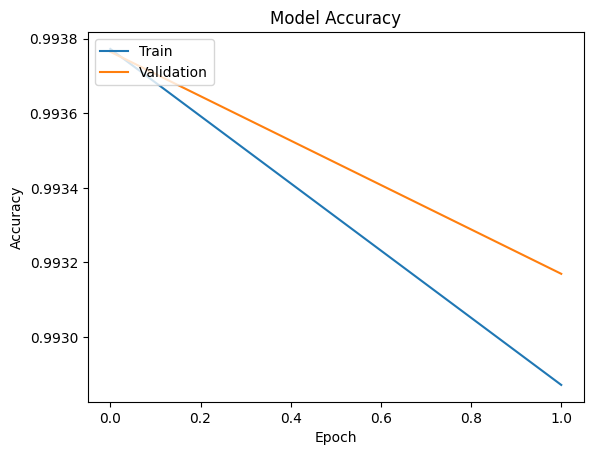

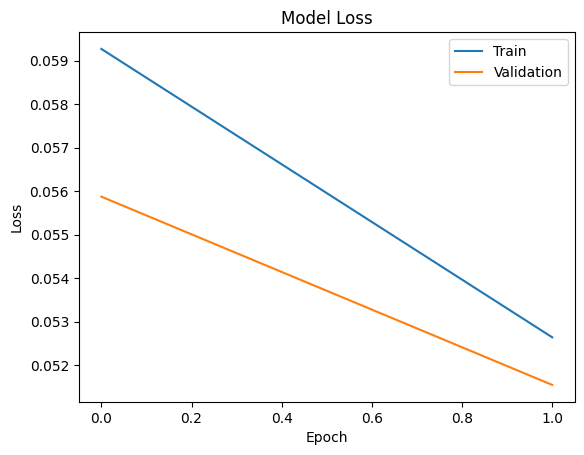

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [30]:
model.save('/content/drive/MyDrive/Toxicity Classification/model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
new_example = ['Hey! you knucklehead']  # Replace with your actual new example
new_example_sequence = tokenizer.texts_to_sequences(new_example)
new_example_padded = pad_sequences(new_example_sequence, maxlen=max_sequence_length)
predictions = model.predict(new_example_padded)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Print the predicted labels
print('Predicted Labels:')
for i, label in enumerate(binary_predictions[0]):
    print(f'Feature {i+1}: {label}')

1/1 [==============================] - 0s 51ms/step
Predicted Labels:
Feature 1: 0
Feature 2: 0
Feature 3: 0
Feature 4: 0
Feature 5: 0
Feature 6: 0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
